In [31]:
import os
import joblib
import numpy as np
import pandas as pd
from spielmacher.player import Move
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import keras_tuner
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

RANDOM_SEED = 42
NUM_ROUNDS = 10
NUM_COLUMNS = NUM_ROUNDS * 2
NUM_EPOCHS = 10
BATCH_SIZE = 32

TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

DATA_DIR = "data"
MODEL_DIR = "models"
PLAYER_NAME = "TitForTatPlayer"

np.set_printoptions(precision=3, suppress=True) # Make numpy values easier to read.
np.random.seed(RANDOM_SEED)  # ensure random outputs are consistent

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# Ingest Data

In [32]:
# Read data from CSV
df = pd.read_csv(f"{DATA_DIR}/{PLAYER_NAME}.csv")
df.head()

,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p1_9,p1_10,...,p2_2,p2_3,p2_4,p2_5,p2_6,p2_7,p2_8,p2_9,p2_10,move
0,E,E,E,E,E,E,E,E,E,E,...,E,E,E,E,E,E,E,E,E,C
1,C,E,E,E,E,E,E,E,E,E,...,E,E,E,E,E,E,E,E,E,C
2,C,C,E,E,E,E,E,E,E,E,...,D,E,E,E,E,E,E,E,E,D
3,C,C,D,E,E,E,E,E,E,E,...,D,C,E,E,E,E,E,E,E,C
4,C,C,D,C,E,E,E,E,E,E,...,D,C,C,E,E,E,E,E,E,C


In [33]:
# Encode moves

encoder = LabelEncoder()

df = df.apply(encoder.fit_transform)

df.head()

,p1_1,p1_2,p1_3,p1_4,p1_5,p1_6,p1_7,p1_8,p1_9,p1_10,...,p2_2,p2_3,p2_4,p2_5,p2_6,p2_7,p2_8,p2_9,p2_10,move
0,1,2,2,2,2,2,2,2,2,0,...,2,2,2,2,2,2,2,2,0,0
1,0,2,2,2,2,2,2,2,2,0,...,2,2,2,2,2,2,2,2,0,0
2,0,0,2,2,2,2,2,2,2,0,...,1,2,2,2,2,2,2,2,0,1
3,0,0,1,2,2,2,2,2,2,0,...,1,0,2,2,2,2,2,2,0,0
4,0,0,1,0,2,2,2,2,2,0,...,1,0,0,2,2,2,2,2,0,0


# Split data into training and testing

In [34]:
# # Select RandomPlayer for testing
# df_train = df.loc[df['opponent'] != 'RandomPlayer']
# df_test = df.loc[df['opponent'] == 'RandomPlayer']

# # Extract features and target
# X_train = df_train.iloc[:, :NUM_COLUMNS].to_numpy()
# y_train = df_train['move'].values

# X_test = df_test.iloc[:, :NUM_COLUMNS].to_numpy()
# y_test = df_test['move'].values

In [35]:
Xs = df.iloc[:, :NUM_COLUMNS].to_numpy()  # get the first 20 columns and convert to numpy array
ys = df["move"].values

X_train, X_test, y_train, y_test = train_test_split(
    Xs, ys, test_size=TEST_SPLIT, random_state=RANDOM_SEED
)

In [36]:
print(f"""
Training:
    X: {X_train.shape}
    y: {y_train.shape}

Testing:
    X: {X_test.shape}
    y: {y_test.shape}
""")


Training:
    X: (160, 20)
    y: (160,)

Testing:
    X: (40, 20)
    y: (40,)



In [37]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = 100 * accuracy_score(y_test, predictions)
    print("Accuracy = {:0.2f}%.".format(accuracy))

In [38]:
def save_model(model, model_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
        
    joblib.dump(model, f"{MODEL_DIR}/{model_name}.joblib")

# RandomForestClassifier

In [39]:
base_rfc = RandomForestClassifier(random_state=RANDOM_SEED)
base_rfc.fit(X_train, y_train)

evaluate(base_rfc, X_test, y_test)
save_model(base_rfc, f"{PLAYER_NAME}_base_rfc")

Accuracy = 87.50%.


## RandomizedSearchCV

In [10]:
rand_param_grid = {
    "bootstrap": [True, False],
    "max_depth": [int(x) for x in np.linspace(10, 110, num=11)],
    "max_features": [1.0, None, "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
}

In [11]:
# Instantiate reg for randomized search
rfc = RandomForestClassifier()

# Conduct the randomized search
rand_search = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=rand_param_grid, 
    cv=3, 
    n_jobs=-1, 
    n_iter=100, 
    verbose=2, 
    random_state=RANDOM_SEED
)

# Fit the grid search to the data
rand_search.fit(X_train, y_train)
print(rand_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=   2.1s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   3.2s
[CV] END bootstrap=True, max_de

In [13]:
# Create a random forest with best parameters
rand_rfc = RandomForestClassifier(
    bootstrap=True,
    max_depth=20,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=800,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

# Fit the model to the data
rand_rfc.fit(X_train, y_train)

evaluate(rand_rfc, X_test, y_test)
save_model(rand_rfc, f"{PLAYER_NAME}_rand_rfc")

RandomForestClassifier(max_depth=20, max_features=None, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=800, n_jobs=-1,
                       random_state=42)

## Grid Search

In [14]:
param_grid = {
    "bootstrap": [True],
    "max_depth": [80, 90, 100, 110],
    "max_features": [1.0, "sqrt", "log2"],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [100, 200, 300, 1000],
}

In [15]:
# Instantiate reg for gridsearch
rfc = RandomForestClassifier()

# Conduct the gridsearch
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time

In [ ]:
# Create a random forest with best parameters
grid_rfc = RandomForestClassifier(
    bootstrap=True,
    max_depth=80,
    max_features=1.0,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

# Fit the model to the data
grid_rfc.fit(X_train, y_train)

evaluate(grid_rfc, X_test, y_test)
save_model(grid_rfc, f"{PLAYER_NAME}_grid_rfc")

RandomForestClassifier(max_depth=80, max_features=1.0, min_samples_leaf=4,
                       min_samples_split=10, n_jobs=-1, random_state=42)

# DecisionTreeClassifier

In [40]:
from sklearn.tree import DecisionTreeClassifier


base_dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
base_dt.fit(X_train, y_train)

evaluate(base_dt, X_test, y_test)
save_model(base_dt, f"{PLAYER_NAME}_base_dt")

Accuracy = 90.00%.


# Support Vector Machine

In [41]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', random_state=RANDOM_SEED)
svm_linear.fit(X_train, y_train)

evaluate(svm_linear, X_test, y_test)
save_model(svm_linear, f"{PLAYER_NAME}_base_svm")

Accuracy = 100.00%.


# TensorFlow

## Basic Model

In [ ]:
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(NUM_COLUMNS,)))
model.add(Dense(1, activation='sigmoid')) # For binary classification

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=VALIDATION_SPLIT
)

Epoch 1/10


/home/mferuscomelo/programming-wsl/spielmacher-reglungstechnik/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4208 - loss: 1.0948 - val_accuracy: 0.4375 - val_loss: 1.0007
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3781 - loss: 1.0760 - val_accuracy: 0.4375 - val_loss: 0.9070
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3885 - loss: 0.9875 - val_accuracy: 0.4375 - val_loss: 0.8329
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3698 - loss: 0.9498 - val_accuracy: 0.5625 - val_loss: 0.7739
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5656 - loss: 0.7918 - val_accuracy: 0.5625 - val_loss: 0.7318
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4729 - loss: 0.7914 - val_accuracy: 0.5938 - val_loss: 0.7009
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5208 - loss: 0.7424 - val_accuracy: 0.6562 - val_loss: 0.6829
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4771 - loss: 0.7708 - val_accuracy: 0.6562 - val_loss: 0.6718
Epoch 9/10


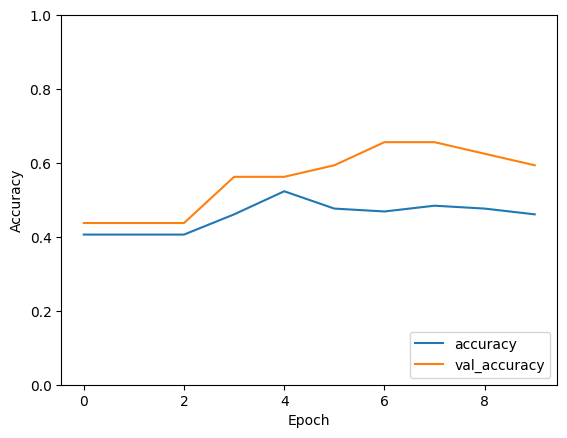

In [43]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [44]:
loss, accuracy = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4896 - loss: 0.7397 


## Hypertuning

In [45]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Choice("dense1", [32, 64, 128]), activation="relu", input_shape=(NUM_COLUMNS,)))
    model.add(Dense(hp.Choice("dense2", [64, 128, 256]), activation="relu"))
    model.add(Dense(hp.Choice("dense3", [64, 128, 256]), activation="relu"))
    model.add(Dense(hp.Choice("dense4", [64, 128, 256]), activation="relu"))
    model.add(Dense(hp.Choice("dense5", [64, 128, 256]), activation="relu"))
    model.add(Dense(hp.Choice("dense6", [64, 128, 256]), activation="relu"))
    model.add(Dense(hp.Choice("dense7", [32, 64, 128]), activation="relu"))
    model.add(Dense(hp.Choice("dense8", [16, 32, 64]), activation="relu"))
    model.add(Dense(1, activation="sigmoid"))  # For binary classification

    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    opt = Adam(learning_rate=lr)

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model


tuner = keras_tuner.BayesianOptimization(build_model, objective="val_accuracy", directory=MODEL_DIR, project_name=PLAYER_NAME)

tuner.search(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=64, 
    validation_split=VALIDATION_SPLIT
)
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.65625

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 01m 11s


/home/mferuscomelo/programming-wsl/spielmacher-reglungstechnik/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
loss, accuracy = best_model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7229 - loss: 0.6191 


In [72]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,297 (1.05 MB)

 Trainable params: 275,297 (1.05 MB)

 Non-trainable params: 0 (0.00 B)